In [258]:
## imports
#%matplotlib qt


import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os, fnmatch
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns
from os import path
from scipy import integrate
import itertools

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [117]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0][0]
    TUpIndex = np.where(time >= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def CutTimesArray(time, Arr, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0] 
    if(len(TLowIndex) > 0):
        TLowIndex = TLowIndex[-1]
    else:
        TLowIndex = 0
    TUpIndex = np.where(time >= TUp)[0]
    if(len(TUpIndex) > 0):
        TUpIndex = TUpIndex[0]
    else:
        TUpIndex = -1
        
    time = time[TLowIndex:TUpIndex]
    Ans = []
    for data in Arr:
        Ans.append(data[TLowIndex:TUpIndex])
    return time, Ans 


def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

def GetCameraPosition(p):
    p = p.split('Trace')[1]
    x = p.split('_')[1]
    y = p.split('_')[2]
    z = p.split('_')[3]
    return '[' + x + ',' + y + ',' + z + ']'

def GetTime(p):
    p = p.split('Trace')[1]
    t = p.split('_')[4]
    t = t.split('/')[0]
    return t

## Read in horizon data 

In [119]:
## Read in horizon trajectories

Lev = "2"

def read_horizon_trajectories(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/HeadOn_Harmonic/JoinedLev" + Lev + "/ApparentHorizons/Trajectory_Ah" + Horizon + ".dat"
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

## Build the horizon interpolants
t_a, x_a, y_a, z_a = read_horizon_trajectories("A")
spl_x_a = InterpolatedUnivariateSpline(t_a, x_a)
spl_y_a = InterpolatedUnivariateSpline(t_a, y_a)
spl_z_a = InterpolatedUnivariateSpline(t_a, z_a)

t_b, x_b, y_b, z_b = read_horizon_trajectories("B")
spl_x_b = InterpolatedUnivariateSpline(t_b, x_b)
spl_y_b = InterpolatedUnivariateSpline(t_b, y_b)
spl_z_b = InterpolatedUnivariateSpline(t_b, z_b)

t_c, x_c, y_c, z_c = read_horizon_trajectories("C")
t_merger = t_b[-1]
t_ringdown = t_c[0]
spl_x_c = InterpolatedUnivariateSpline(t_c, x_c)
spl_y_c = InterpolatedUnivariateSpline(t_c, y_c)
spl_z_c = InterpolatedUnivariateSpline(t_c, z_c)

def horizon_at_time(time, Horizon):
    if Horizon == "A":
        return spl_x_a(time), spl_y_a(time), spl_z_a(time)
    if Horizon == "B":
        return spl_x_b(time), spl_y_b(time), spl_z_b(time)
    if Horizon == "C":
        return spl_x_c(time), spl_y_c(time), spl_z_c(time)
    else:
        print("Unrecognized horizon argument")

def distance_sqr(xx, yy, zz, xx_h, yy_h, zz_h):
    return (xx - xx_h)**2 + (yy - yy_h)**2 + (zz - zz_h)**2
    
def distance_to_horizon(time, xx, yy, zz):
    """ time, x,x yy, zz are scalars for the position"""
    if time <= t_merger:
        min_dist = 1e10
        for horizon in ["A", "B"]:
            """ Have to minimize over AhA and AhB distances"""
            xx_h, yy_h, zz_h = horizon_at_time(time, horizon)
            dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
            min_dist = min(min_dist, dist)
        return sqrt(min_dist)
    elif time > t_merger:
        xx_h, yy_h, zz_h = horizon_at_time(time, "C")
        dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
        return sqrt(dist)
    else:
        print("somehow here")
        print(time, t_merger, t_ringdown)
                
def min_distance_to_horizon(t, x, y, z):
    """ Returns the minimum distance of a geodesic to a horizon over all time
        t, x, y, z are arrays with the history of the geodesic"""
    min_distance = 1e10
                
    ## minimize over the times
    for time, xx, yy, zz in zip(t, x, y, z):
        dist_horizon = distance_to_horizon(time, xx, yy, zz)
        min_distance = min(min_distance, dist_horizon)

    return(sqrt(min_distance))
            

## Read in lensing camera data

In [120]:
## Lensing camera data
def GetCameraData(p):
    
    file = p + 'RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['LensingCore.dat']
    
    tags = data[:,0]
    tags = tags.astype(int)
    x_pos = data[:,1]
    y_pos = data[:,2]
    surface = data[:,4]
    
    return tags, x_pos, y_pos, surface

def GrabSurfaceIndices(surface, fate):
    
    i = np.where(surface == fate)[0]
    return i

def SelectCameraGeodesics(p, fate):
    
    tags, x_pos, y_pos, surface = GetCameraData(p)
    
    i = np.where(surface == fate)[0]
    
    return tags[i], x_pos[i], y_pos[i], surface[i]
    
def GetInfinityGeodesics(p):
    """ 
    inf = np.where(surface == 1.)[0]
    infty = np.where(surface == 7.)[0]
    aha = np.where(surface == 2.)[0]
    ahb = np.where(surface == 3.)[0]
    ahc = np.where(surface == 4.)[0]
    """
    file = p + 'RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['LensingCore.dat']
    surface = data[:,4]
    #return GrabSurfaceIndices(surface, 1)
    return GrabSurfaceIndices(surface, 7)
    


## Read in geodesics trajectories

In [164]:
## Read geodesic trajectories from Node0.h5 and dump to .dat files

def ReadGeodesicData(p, t_start, t_end):
    """ Read in an array of times and positions for all geodesics at once, 
        and return the trajectories indexed by geodesic """
        
    def AppendGeodesicsTime(Lev, Run):

        print("Reading Geodesic data for " + Lev + " and " + Run)

        file = p + '/' + Lev + '/' + Run + '/Run/Node0.h5'
        f = h5py.File(file, 'r')
        ## grab the .dat files
        keys = [k for k in f.keys() if 'dat' in k]
        ## Array of times from the .dat files
        times = [float(k.split('.dat')[0]) for k in keys]
        ## sort keys according to times
        times, keys = zip(*sorted(zip(times, keys)))
        # grab the number of geodesics
        N_geodesics = len(f[keys[-1]][:,0])
        print("Total geodesics: ", N_geodesics, "Time steps: ", len(times))
        ## Minimum index
        m = int(f[keys[-1]][:,0][0])
        print("Geodesic index offset of this refinement iteration: ", m)
    
        X = [ [] for _ in range(N_geodesics)]
        Y = [ [] for _ in range(N_geodesics)]
        Z = [ [] for _ in range(N_geodesics)]
        L = [ [] for _ in range(N_geodesics)]
        T = [ [] for _ in range(N_geodesics)]
    
        for k, t in zip(keys, times):
            print(t)
            if ((t > t_start) and (t < t_end)):
                print("%.1f  " % t, end = '')
                data = f[k]
                ## indices and positions for all geodesics at this time
                indices = data[:,0]
                if (len(data[0]) == 7):
                    """ If we've run the numerical evolution so that we haven't 
                        evolved lapse p0 -- just set lapsep0 to 1 in the files. 
                        This field need to be in the resulting .dat file for the 
                        paraview trajectory visualization"""
                    x = data[:,4]
                    y = data[:,5]
                    z = data[:,6]
                    l = np.ones(len(x))
                elif (len(data[0]) == 8):
                    """ If we have evolved lapse p0"""
                    l = data[:,1]
                    x = data[:,5]
                    y = data[:,6]
                    z = data[:,7]
                else:
                    print("Unrecognized number of variables")
                ## fill in the array for each index
                for i, j in zip(indices.astype(int), range(len(indices))):
                    X[i-m] = np.append(X[i-m], x[j])
                    Y[i-m] = np.append(Y[i-m], y[j])
                    Z[i-m] = np.append(Z[i-m], z[j])
                    L[i-m] = np.append(L[i-m], l[j])
                    T[i-m] = np.append(T[i-m], t)

        print("\n")
        ## Once we have the arrays constructed, append them to the file
        print('Read the geodesic data, now writing the files')
        print("Masha", len(T))
        for a in range(len(T)):
            ##if (len(T[a]) > 1):
                ## Remember to add in the minimum index since the starting 
                ## geodesic index just gets incremented during reach refinement
                ## level (by the number of geodesics that came from the levels before)
            ff = open(p + '/Trajectories/' + str(a + m) + '.dat','ab')
            np.savetxt(ff, np.c_[T[a],X[a],Y[a],Z[a],L[a]])
            ff.close()
        print('Finished writing the files')
            
    ## Go through the refinement levels and the segments
    RefinementLevs = [el for el in os.listdir(p) if "Lev" in el]
    print("RefinementLevs:", RefinementLevs)
    for lev in RefinementLevs:
        Segments = os.listdir(p + '/' + lev)
        print(lev + " Segments:", Segments)
        for segment in Segments:
            AppendGeodesicsTime(lev, segment)

def MakeGeodesicDatFiles(p, t_start, t_end):
    """ Print the result of ReadGeodesicData to files """
    ReadGeodesicData(p, t_start, t_end)

## Functions for reading GetTrajectoriesFromH5 output
def GetGeodesicTrajectory(p, n, Culled = False):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + 'Trajectories/' + str(n) + '.dat'
    if Culled:
        f = p + 'CulledTrajectories/' + str(n) + '.dat'
    #t, x, y, z, lapse = np.loadtxt(f, comments="#",usecols=([0,5,6,7,1]),unpack=True)
    t, x, y, z, lapse = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4]),unpack=True)
    return t, x, y, z, lapse

def GetGeodesicIndices(p, infinity=True):
    """ Return the indices of all of the geodesics we have printed to file 
        If infinity == True, only returnt the geodesics that make it out to infinity """
    Files = os.listdir(p + '/Trajectories')
    Indices = [int(file.split('.dat')[0]) for file in Files]
    Indices = sorted(Indices)
    if infinity:
        indices_infinity = GetInfinityGeodesics(p)
        Indices = list(set(indices_infinity) & set(Indices))
    return Indices

## Zero crossings computations

In [173]:
## Zero crossings computations
def ComputeZeroCrossings(p, n):
    """ Compute the number of zero crossings in the y-z plane - 
        useful for head-on runs where the collision happens
        along the x axis """
    t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
    theta = np.arctan2(z, y)
    zero_crossings = len(np.where(np.diff(np.sign(theta)))[0])
    return zero_crossings

def MakeZeroCrossingsFile(p):
    """ Make a file with the format [geodesic index, number of zero crossings] so 
        that we only have to compute the number of zero crossings once """
    ns = GetGeodesicIndices(p)
    crossings = [ComputeZeroCrossings(p, n) for n in ns]
    np.savetxt(p + 'ZeroCrossings.dat', np.c_[ns, crossings], fmt = '%d %d')
    
def GetGeodesicsZeroCrossings(p):
    """ Return the zero crossings for each index """
    f = p + 'ZeroCrossings.dat'
    ns, zero_crossings = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True,dtype=int)
    return ns, zero_crossings

def GetGeodesicsZeroCrossingsIndices(p, N, infinity=True):
    """ Return the indices of the geodesics that make N zero-crossings 
        If infinity == True, return only the ones that make it to infinity"""
    f = p + 'ZeroCrossings.dat'
    ns, zero_crossings = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True,dtype=int)
    indices = ns[np.where(zero_crossings == N)[0]]
    if infinity:
        indices_infinity = GetInfinityGeodesics(p)
        indices = list(set(indices_infinity) & set(indices))
    return indices

def GetGeodesicsMaxZeroCrossings(p, infinity=True):
    """ Return the maximum number N of zero crossings for a given run, 
        along with the indices of the geodesics that make N zero-crossings 
        If infinity == Ture, only return the ones that make it to infinity"""
    f = p + 'ZeroCrossings.dat'
    ns, zero_crossings = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True,dtype=int)
    max_N = max(zero_crossings)
    indices = GetGeodesicsZeroCrossingsIndices(p, max_N, infinity=infinity)
    return max_N, indices
    


## X-crossings computation

In [267]:
## X-crossings computations
def ComputeXTurns(p, n):
    """ Compute tbe number of turns a geodesic makes along the x direction
        Useful for head-on runs where the collision happens along the x axis"""
    t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
    x_diff = x[1:] - x[:-1]
    turns = len(list(itertools.groupby(x_diff, lambda x_diff: x_diff > 0)))
    return turns 

def MakeXTurnsFile(p):
    """ Make a file with the format [geodesic index, number of X turns] so 
        that we only have to compute the number of X turns once """
    ns = GetGeodesicIndices(p)
    turns = [ComputeXTurns(p, n) for n in ns]
    np.savetxt(p + 'XTurns.dat', np.c_[ns, turns], fmt = '%d %d')
    

    
ComputeXTurns('Data/TraceHeadOn_0_0_100_269.7/', 90560)


[ 4.61615973e-01  4.61566226e-01  4.61515966e-01  4.61465181e-01
  4.61413860e-01  4.61361993e-01  4.61309569e-01  4.61256577e-01
  4.61203007e-01  4.61148846e-01  4.61094086e-01  4.61038713e-01
  4.60982719e-01  4.60926092e-01  4.60868821e-01  4.60810895e-01
  4.60752304e-01  4.60693037e-01  4.60633082e-01  4.60572429e-01
  4.60511068e-01  4.60448987e-01  4.60386175e-01  4.60322622e-01
  4.60258317e-01  4.60193249e-01  4.60127407e-01  4.60060779e-01
  4.59993301e-01  4.59924969e-01  4.59855782e-01  4.59785720e-01
  4.59714765e-01  4.59642899e-01  4.59570102e-01  4.59496357e-01
  4.59421644e-01  4.59345945e-01  4.59269241e-01  4.59191514e-01
  4.59112744e-01  4.59032914e-01  4.58952005e-01  4.58870075e-01
  4.58787392e-01  4.58703507e-01  4.58618338e-01  4.58531864e-01
  4.58444066e-01  4.58354925e-01  4.58264421e-01  4.58172534e-01
  4.58079246e-01  4.57984537e-01  4.57888386e-01  4.57790776e-01
  4.57691686e-01  4.57591097e-01  4.57488989e-01  4.57385344e-01
  4.57280141e-01  4.57173

## Plot geodesic trajectories

In [263]:
## Plot geodesic trajectories
def PlotGetTrajectoriesFromH5(p):

    max_N, Indices = GetGeodesicsMaxZeroCrossings(p)
    print(p, max_N, len(Indices), Indices)
    
    Indices = GetGeodesicsZeroCrossingsIndices(p, 6)
    #Indices = GetGeodesicIndices(p)
    print(len(Indices))
    
    Indices = Indices[0:5]
    
    cs = sns.color_palette('Paired', n_colors=len(Indices))
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    for n, color in zip(Indices, cs):
        t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
        ax.plot(x, y, z, lw = 2.0, label = n, color = color)

                
    #Add in the horizons
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, y_h, z_h, color='black', lw = 2.0, ls='-')

    ax.set_xlabel('x/M',labelpad=20)
    ax.set_ylabel('y/M', labelpad=20)
    ax.set_zlabel('z/M', labelpad=20)
    
    lim = 10.0
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    ax.set_title('Camera = ' + GetCameraPosition(p) + ' M' + ', $t_\mathrm{start}$ = ' + \
                 GetTime(p) + ' M', fontsize=20, loc='left')
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    #ax.set_axis_off()

    plt.legend()
    #plt.tight_layout()
    plt.show()
    


Data/TraceHeadOn_0_0_100_269.7/ 7 1 [92378]
9


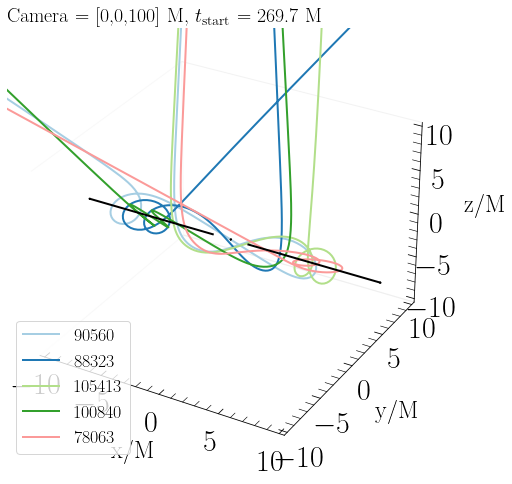

In [264]:
for t_start in [269.7]:
#for dir in fnmatch.filter(os.listdir('Data'), 'Trace*'):
    #p = 'Data/' + dir + '/'
    p = 'Data/TraceHeadOn_0_0_100_' + str(t_start) + '/'
    #max_N, Indices = GetGeodesicsMaxZeroCrossings(p)
    #print(p, max_N, len(Indices))
    PlotGetTrajectoriesFromH5(p)

## Plot time geodesics

In [274]:
## Plot geodesic trajectories in a time - x coordinate plot
def PlotTimeTrajectories(p):

    #max_N, Indices = GetGeodesicsMaxZeroCrossings(p)
    #if max_N == 7:
    #    max_N = 6
    #    Indices = GetGeodesicsZeroCrossingsIndices(p, 6)
    #print(p, max_N, len(Indices))
    Indices = GetGeodesicIndices(p)
    Indices = Indices[::100]
    #Indices = [90560]

    cs = sns.color_palette('Paired', n_colors=len(Indices))
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    for n, color in zip(Indices, cs):
        t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
        #plt.plot(x, t, lw = 2.0, color = color)
        plt.plot(x, t, lw = 0.5, color = 'blue', alpha=0.1)

                
    #Add in the horizons
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, t_h, color='black', lw = 2, ls='-', alpha=0.3)

    plt.ylabel('t/M')
    plt.xlabel('x/M')
    plt.xlim(-20, 20)
    plt.ylim(0, t[-1])
    #plt.ylim(100, 200)
    
    ax.set_title('Camera = ' + GetCameraPosition(p) + ' M' + ', $t_\mathrm{start}$ = ' + \
                 GetTime(p) + ' M', fontsize=20, loc='left')
    plt.axhline(153.81, color='red', ls = '--', lw = 1.0)
    plt.axhline(float(GetTime(p)) - 100, color='pink', lw = 1.0)

    #plt.legend()
    #plt.tight_layout()
    plt.show()
    


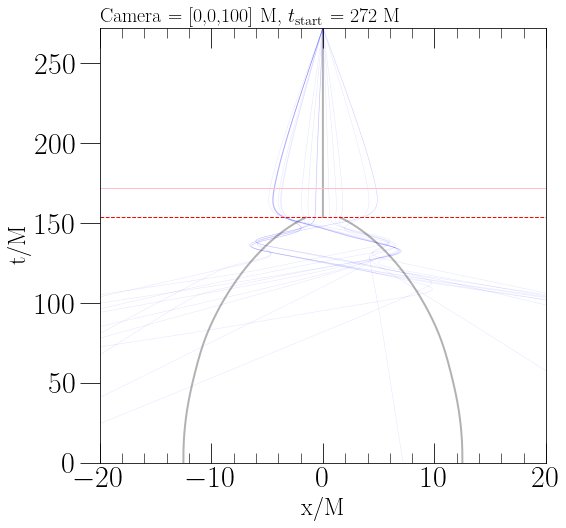

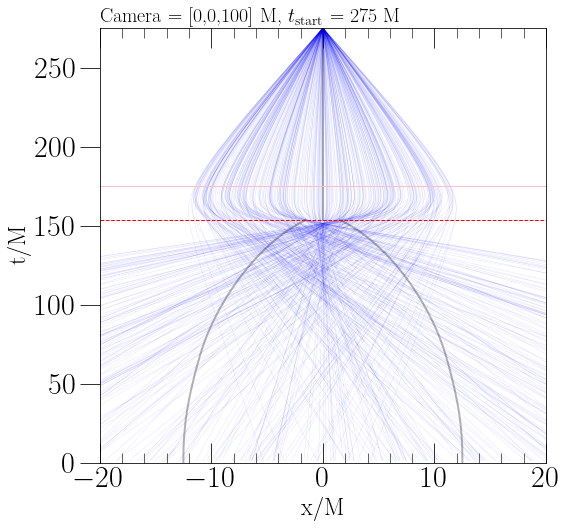

In [277]:
for t_start in [272, 275]: #, 260, 265, 268.6, 269.7, 272, 275]:
    p = 'Data/TraceHeadOn_0_0_100_' + str(t_start) + '/'
    PlotTimeTrajectories(p)

## Plot lensing refinement method results + final positions

In [40]:
## Plot X, Y camera data and kappas on top of it

def PlotRefinementMethodResult(p, shadow=False, zero_crossings=False):
    
    tags, x_pos, y_pos, surface = GetCameraData(p)

    fig = plt.figure(figsize=(10,8))
    
    if shadow:
        
        s = 5.0
    
        inf = GrabSurfaceIndices(surface, 1)
        aha = GrabSurfaceIndices(surface, 2)
        ahb = GrabSurfaceIndices(surface, 3)
        ahc = GrabSurfaceIndices(surface, 4)
        infty = GrabSurfaceIndices(surface, 7)
        
        #plt.scatter(x_pos[infty], y_pos[infty], s=s, c='#aeebd8', label=r'Out to $\infty$')
        #plt.scatter(x_pos[inf], y_pos[inf], s=s, c='lightblue', label=r'Out to $\infty$')
        #plt.scatter(x_pos[aha], y_pos[aha], s=s, c='#00abd1', label=r'Close to AH A')
        plt.scatter(x_pos[ahb], y_pos[ahb], s=s, c='#d10084', label=r'Close to AH B', picker = 1)
        #plt.scatter(x_pos[ahc], y_pos[ahc], s=s, c='black', label=r'Close to Final AH')
        
        #tolerance = 1 # points
        #ax.plot(range(10), 'o', picker=tolerance)
        
        def on_pick(event):
            ind = event.ind
            print(ind, x_pos[ahb][ind], y_pos[ahb][ind], tags[ahb][ind])
            print()

        fig.canvas.callbacks.connect('pick_event', on_pick)
    
    elif zero_crossings:
        
        s = 1.0
        nums = [1, 2, 3, 4, 5, 6, 7] #, 4, 3, 2, 1, 0]
        #nums = [4]
        cs = ['orange', 'purple', '#00eeff', 'black', 'blue', 'red', 'yellow', 'black']
        infty = GrabSurfaceIndices(surface, 7)
        indices, zero = GetGeodesicsZeroCrossings(p)
        print(max(zero))
        for num, color in zip(nums, cs):
            indx = GrabSurfaceIndices(zero, num)
            #ii = list(set(indx) & set(infty))
            ii = list(indx)
            plt.scatter(x_pos[ii], y_pos[ii], s=s, label=str(num), color=color, picker = 1)

            def on_pick(event):
                ind = event.ind
                print(ind, x_pos[ii][ind], y_pos[ii][ind], tags[ii][ind])
                print()

            if len(nums) == 1:
                fig.canvas.callbacks.connect('pick_event', on_pick)

        
    plt.title('Camera = ' + GetCameraPosition(p) + ' M' + ', $t_\mathrm{start}$ = ' + \
                 GetTime(p) + ' M', fontsize=20, loc='left')

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    if shadow:
        legend = plt.legend(title='Geodesic Fate', loc='upper left', fontsize=16, framealpha=1.0)
        plt.setp(legend.get_title(),fontsize=20)
        for han in legend.legendHandles:
            han._sizes = [30]
    if zero_crossings:
        legend = plt.legend(title='Number of zero crossings', ncol = 3, \
                            loc='upper left', fontsize=16, framealpha=1.0)
        plt.setp(legend.get_title(),fontsize=20)
        for han in legend.legendHandles:
            han._sizes = [30]
            
    lim = 0.25
    plt.xlim(0.5 - lim, 0.5 + lim)
    plt.ylim(0.5 - lim, 0.5 + lim)
    plt.tight_layout()
#     if shadow:
#         plt.savefig('Shadow_' + GetTime(p) + '.pdf')
#     if zero_crossings: 
#         plt.savefig('Zero_' + GetTime(p) + '.pdf')
#     else: 
#         plt.savefig('ZoomCamera_' + GetTime(p) + '.pdf')
    #plt.show()
    

7
6


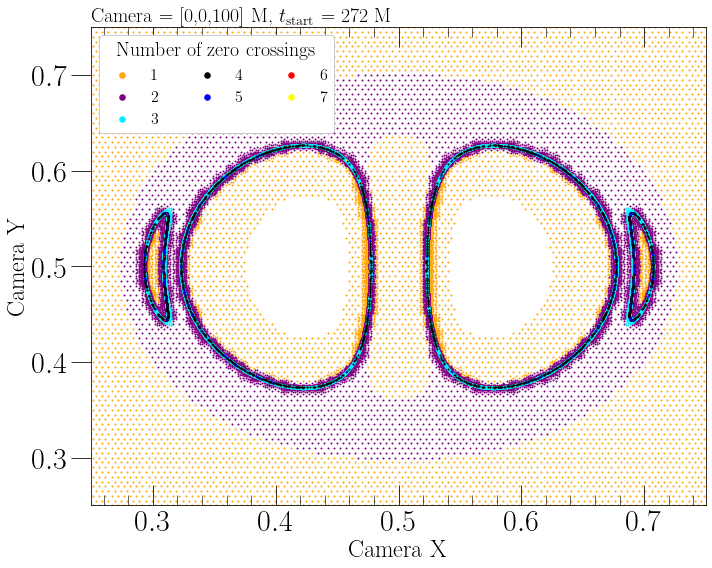

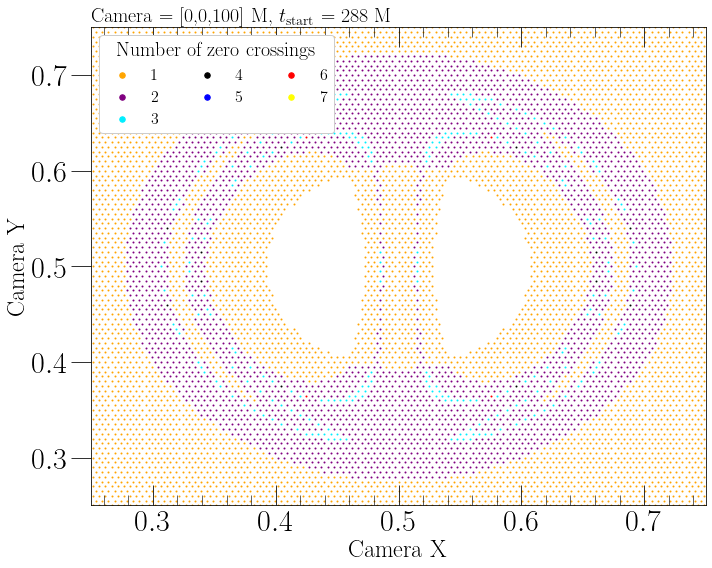

In [243]:
pp_arr = [272, 288]
data_locs = ['Data/TraceHeadOn_0_0_100_' + str(pp) + '/' for pp in pp_arr]
for p in data_locs:
    #PlotRefinementMethodResult(p, shadow=True)
    PlotRefinementMethodResult(p, zero_crossings=True)

In [ ]:
## Interpolate a quantity (like the max Frenet-Serret curvature) onto the camera data
def CameraInterpolation(p):

    file = p + 'RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['LensingCore.dat']
    
    tags = data[:,0]
    print(len(tags))
    tags = tags.astype(int)
    x_pos = data[:,1]
    y_pos = data[:,2]
    surface = data[:,4]
    
    tags_fs, kappas = GetFrenetSerretMaxCurvatures(p)
    print(min(kappas), max(kappas))
    kappas = np.log10(kappas)

    fig = plt.figure(figsize=(10,8))
    
    z = np.array(kappas)
    rows = np.array(x_pos) 
    cols = np.array(y_pos) 
    
    ## Number of points to interpolate to
    YY = 1000
    XX = 1000
    ## number of contours
    N_cont = 1000 
    ## Bounds for the colobar
    cmap = 'jet'
    vmin = 3.0
    vmax = 3.6
    lim = 0.2
    ## Bounds for the figure

    
    xi = np.linspace(0.5 - lim, 0.5 + lim, XX)
    yi = np.linspace(0.5 - lim, 0.5 + lim, YY)

    GD = scipy.interpolate.griddata((rows, cols), z.ravel(),
                          (xi[None,:], yi[:,None]), method='cubic')

    CS = plt.contourf(xi,yi,GD,N_cont,cmap = cmap, vmin=vmin, vmax=vmax)

    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(GD)
    m.set_clim(vmin, vmax)
    cbar = plt.colorbar(m, boundaries=np.linspace(vmin, vmax, 6), fraction=0.03, pad=0.01,  orientation="vertical")
    cbar.set_label(r'Max $\log_{10} \kappa$', rotation=-90, labelpad=20)
    
    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.show()